In [2]:
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    
    Args:
        features_path (str): Path to the .npy file containing features
        labels_path (str): Path to the .npy file containing labels
        segment_info_path (str): Path to the CSV file containing segment information
    
    Returns:
        X (np.array): Feature matrix
        y (np.array): Labels
        segment_info (pd.DataFrame): DataFrame containing segment information
    """
    # Load features and labels
    X = np.load(features_path)
    y = np.load(labels_path)
    
    # Load segment info
    segment_info = pd.read_csv(segment_info_path)
    
    # Verify that the number of samples matches
    assert len(X) == len(y) == len(segment_info), \
        "Mismatch in number of samples between features, labels, and segment info"
    
    return X, y, segment_info

def participant_independent_split(X, y, segment_info, test_size=0.2, random_state=42):
    """
    Split data ensuring complete participant independence between train and test sets.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Labels
        segment_info (pd.DataFrame): DataFrame containing segment information
        test_size (float): Proportion of participants to use for testing
        random_state (int): Random seed
    
    Returns:
        X_train, X_test, y_train, y_test, train_indices, test_indices
    """
    # Get unique participants
    participants = segment_info['participant_id'].unique()
    
    # Split participants into train and test
    n_test_participants = max(1, int(len(participants) * test_size))
    np.random.seed(random_state)
    test_participants = np.random.choice(participants, n_test_participants, replace=False)
    train_participants = np.array([p for p in participants if p not in test_participants])
    
    
    overlap = set(train_participants) & set(test_participants)
    assert not overlap, f"Participant overlap between train and test: {overlap}"
    if overlap:
        print("⚠️  Warning: participant overlap detected:", overlap)
        
    print("Split OK – no participant overlap.")
    print("Train IDs:", sorted(train_participants))
    print("Test  IDs:", sorted(test_participants))
    
    # For augmented data, handle original and augmented segments
    is_augmented = segment_info['segment_path'].str.contains('_aug\\d+\\.wav').any()
    
    if is_augmented:
        # Get indices for train and test (including augmented versions)
        train_indices = segment_info[
            segment_info['participant_id'].isin(train_participants)
        ].index
        
        # For test, only use original (non-augmented) segments from test participants
        test_indices = segment_info[
            (segment_info['participant_id'].isin(test_participants)) &
            (~segment_info['segment_path'].str.contains('_aug\\d+\\.wav'))
        ].index
    else:
        # Simple split for non-augmented data
        train_indices = segment_info[
            segment_info['participant_id'].isin(train_participants)
        ].index
        test_indices = segment_info[
            segment_info['participant_id'].isin(test_participants)
        ].index
    
    # Convert to arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Print split statistics
    print(f"\nParticipant-Independent Split Statistics:")
    print(f"Training participants: {sorted(train_participants)}")
    print(f"Test participants: {sorted(test_participants)}")
    print(f"\nTraining set size: {len(train_indices)}")
    print(f"Test set size: {len(test_indices)}")
    print("\nLabel distribution in training set:")
    print(pd.Series(y[train_indices]).value_counts())
    print("\nLabel distribution in test set:")
    print(pd.Series(y[test_indices]).value_counts())
    
    return (X[train_indices], X[test_indices], 
            y[train_indices], y[test_indices],
            train_indices, test_indices)

def train_evaluate_knn_participant_independent(X_train, X_test, y_train, y_test, segment_info_train, cv=5):
    """
    Train KNN model with participant-independent cross-validation and proper handling of augmented data groups.
    
    Args:
        X_train, X_test: Training and test feature matrices
        y_train, y_test: Training and test labels
        segment_info_train: DataFrame containing segment information for training data
        cv: Number of cross-validation folds
    """
    # Create group IDs for cross-validation
    # Remove trailing "_augN.wav" so original and augmented versions share same group ID
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    print("\nLabel mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize KNN and GroupKFold
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=cv)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train_scaled, y_train_enc)
    
    # Get best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Print cross-validation results
    print("\nCross-validation results:")
    print("Best parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    # Evaluate on test set
    y_pred_enc = best_model.predict(X_test_scaled)
    
    # Convert predictions back to original labels for reporting
    y_pred = le.inverse_transform(y_pred_enc)
    
    print("\nTest Set Evaluation:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    return best_model, best_params, grid_search.cv_results_

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

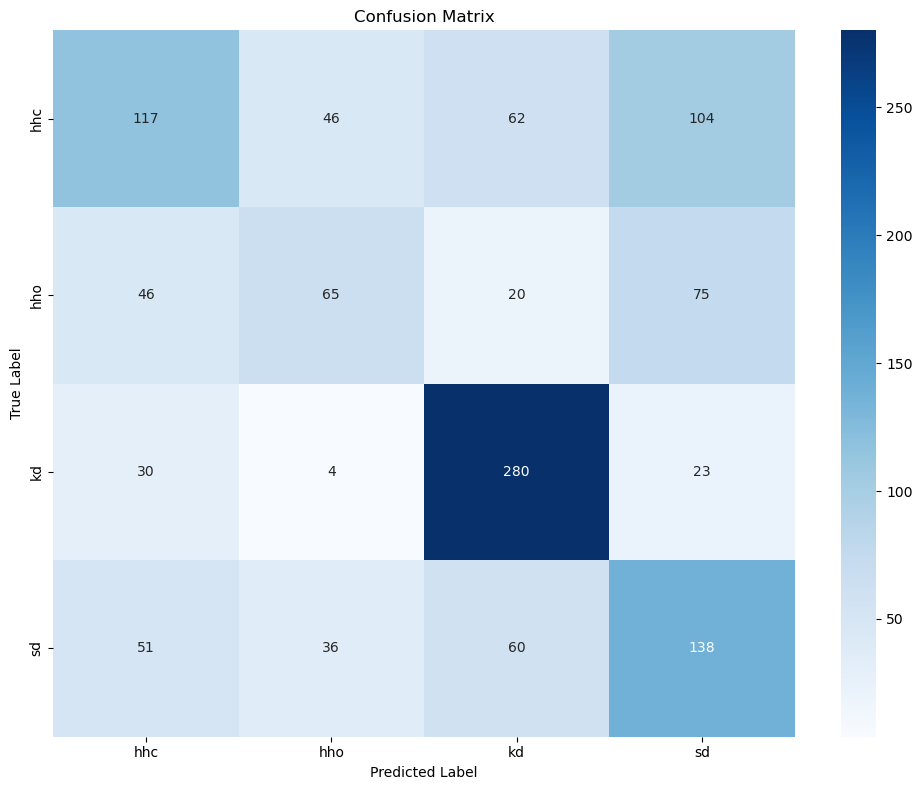

In [7]:
X, y, segment_info = load_features_and_labels(
        "../../extracted_features/features/mfcc_features.npy",
        "../../extracted_features/labels/mfcc_labels.npy",
        "../../segment_info/segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

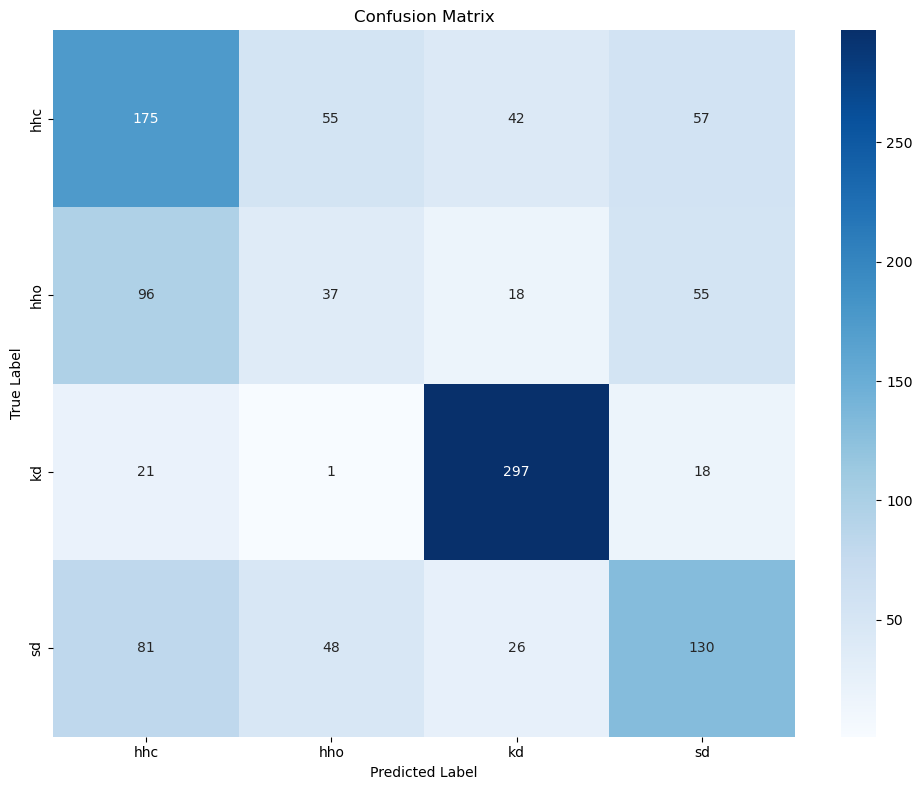

In [8]:
X, y, segment_info = load_features_and_labels(
        "../../extracted_features/features/mfcc_env_features.npy",
        "../../extracted_features/labels/mfcc_env_labels.npy",
        "../../segment_info/segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

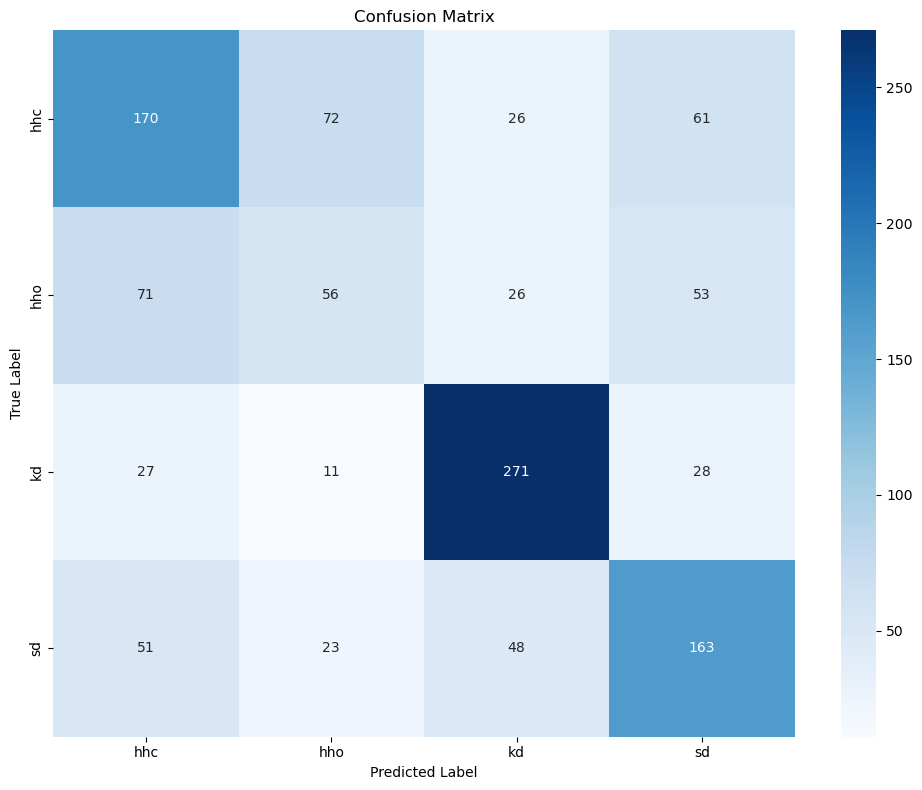

In [9]:
X, y, segment_info = load_features_and_labels(
        "../../extracted_features/features/mfcc_extracted_features.npy",
        "../../extracted_features/labels/mfcc_extracted_labels.npy",
        "../../segment_info/segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

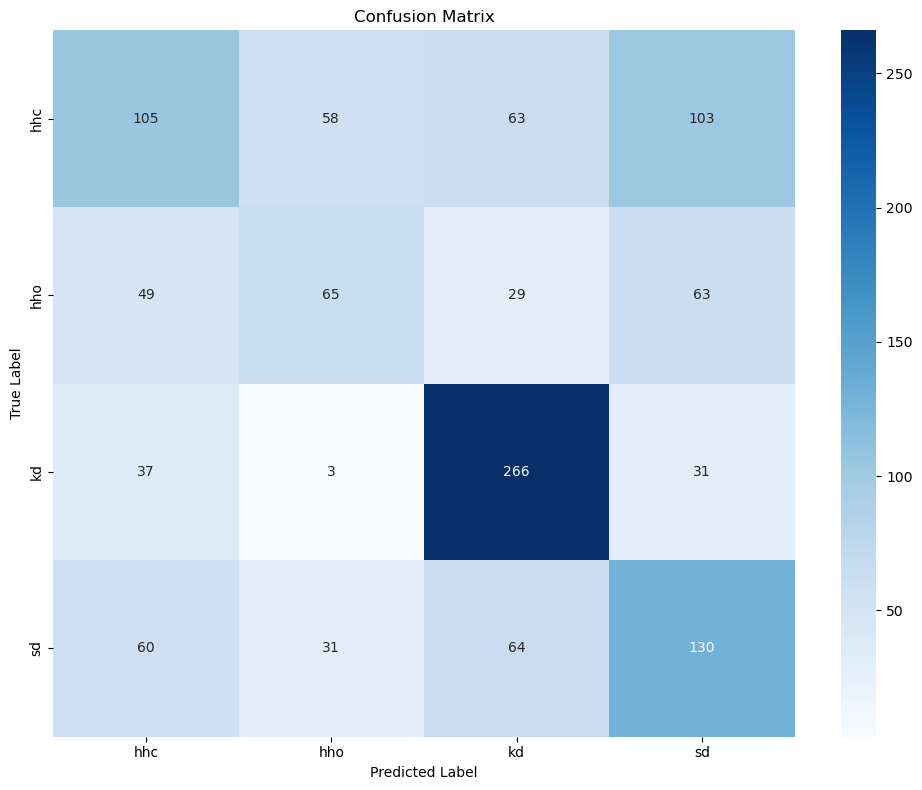

In [10]:
X, y, segment_info = load_features_and_labels(
        "../../extracted_features/features/mfcc_features_aug.npy",
        "../../extracted_features/labels/mfcc_labels_aug.npy",
        "../../segment_info/augmented_segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

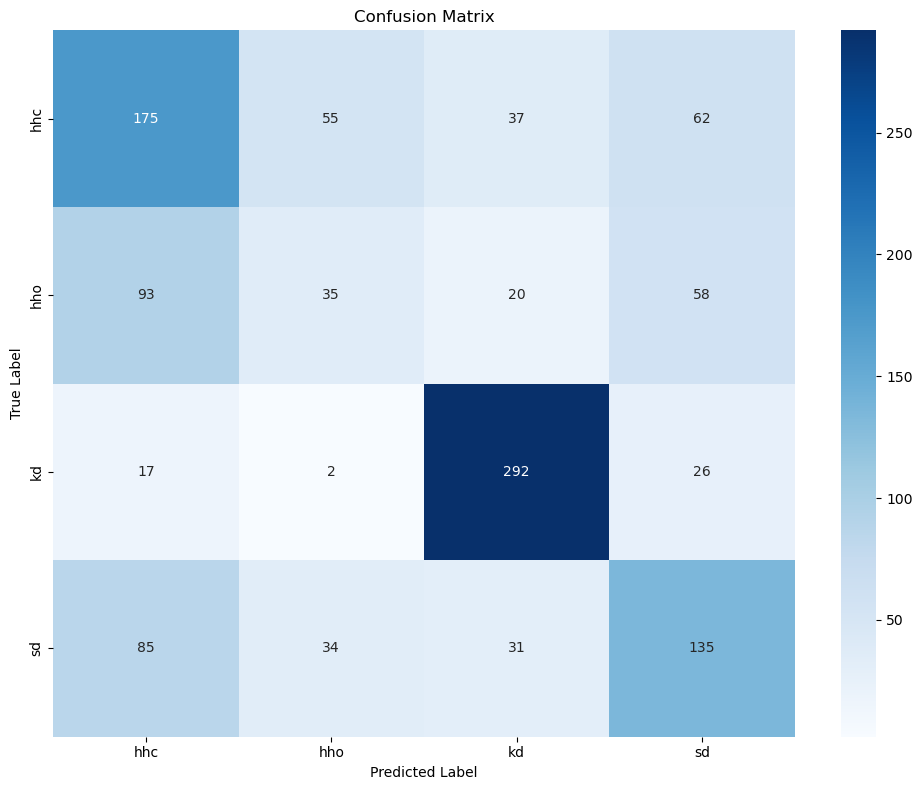

In [11]:
X, y, segment_info = load_features_and_labels(
        "../../extracted_features/features/mfcc_env_aug_features.npy",
        "../../extracted_features/labels/mfcc_env_aug_labels.npy",
        "../../segment_info/augmented_segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

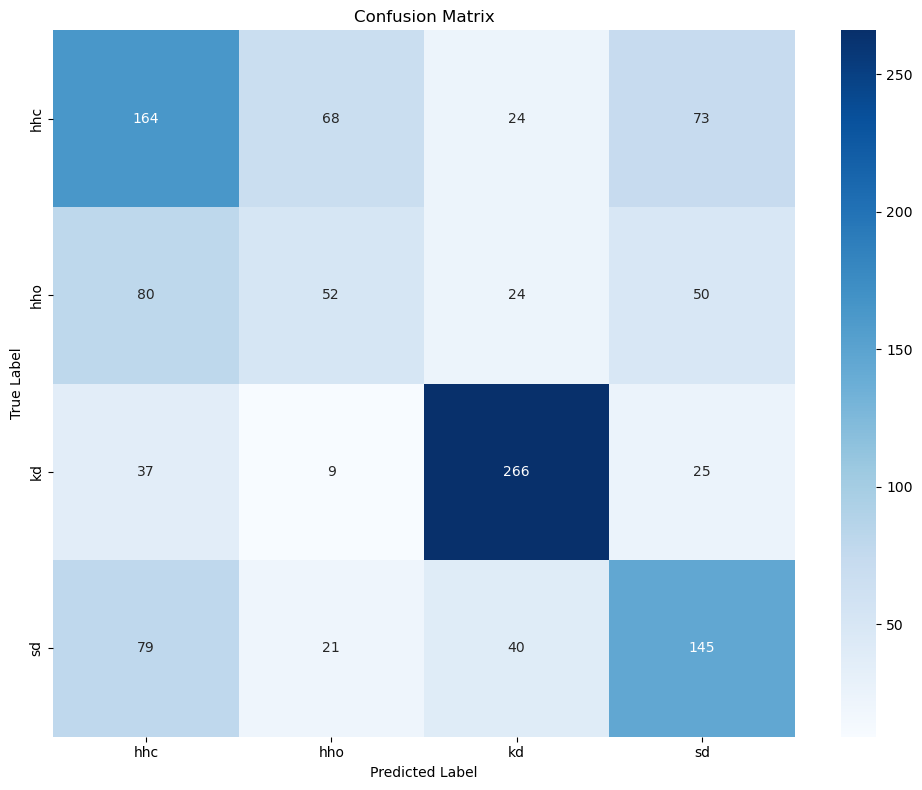

In [12]:
X, y, segment_info = load_features_and_labels(
        "../../extracted_features/features/mfcc_extracted_aug_features.npy",
        "../../extracted_features/labels/mfcc_extracted_aug_labels.npy",
        "../../segment_info/augmented_segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )

Split OK – no participant overlap.
Train IDs: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI']
Test  IDs: ['AFRP', 'JSoI', 'MarI', 'MarP', 'P13', 'P14', 'P18', 'P20', 'P24', 'P7', 'SofI', 'ZgaP', 'ZizP']

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AZiI', 'AZiP', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSiP', 'JoSP', 'MCoI', 'MCoP', 'MafI', 'MafP', 'NorI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P25', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P8', 'P9', 'RicI', 'RicP

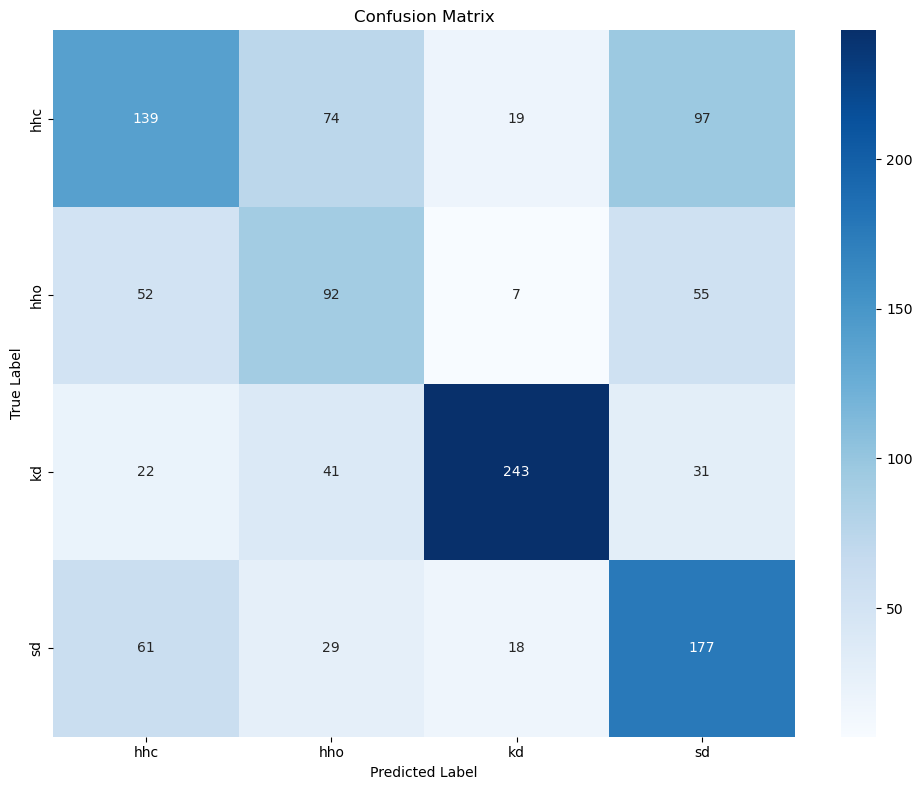

In [4]:
X, y, segment_info = load_features_and_labels(
        "cnn_syllable_features.npy",
        "../../extracted_features/labels/mfcc_labels.npy",
        "../../segment_info/segment_info.csv"
)
    
    # Get participant-independent split
X_train, X_test, y_train, y_test, train_idx, test_idx = participant_independent_split(
        X, y, segment_info
)
    
    # Train and evaluate model with proper grouping
best_model, best_params, cv_results = train_evaluate_knn_participant_independent(
        X_train, X_test, y_train, y_test,
        segment_info.iloc[train_idx],  # Pass only training segment info
        cv=5
    )